In [1]:
import pickle
import pandas as pnd
from pathlib import Path
from collections import defaultdict, Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from src import plotting

In [2]:
DATA_FOLDER = Path("/path/to/data/folder/")

Load data:

In [3]:
with open(DATA_FOLDER / "topic_modelling_data.pkl", "rb") as f:
    (keys,
     vectorizer, tfidf_matrix,
     topic_model, w_matrix,
     scaler, w_matrix_norm,
     tsne_reducer, reduced) = pickle.load(f)

In [4]:
with open(DATA_FOLDER / "PDB_coords.pkl", "rb") as f:
    pdb_coords = pickle.load(f)
AF_dataframe = pnd.read_csv(DATA_FOLDER / "AF_dataframe.txt", sep="\t")
AF_dataframe = AF_dataframe.set_index("ID")
PDB_dataframe = pnd.read_csv(DATA_FOLDER / "PDB_dataframe.txt", sep="\t")
PDB_dataframe = PDB_dataframe.set_index("PDB_ID")

Figure 1: t-SNE of all AF and PDB proteins
Top 20 superfamilies coloured

In [5]:
from matplotlib import cm
CMAP_COLORS = cm.get_cmap("tab20").colors

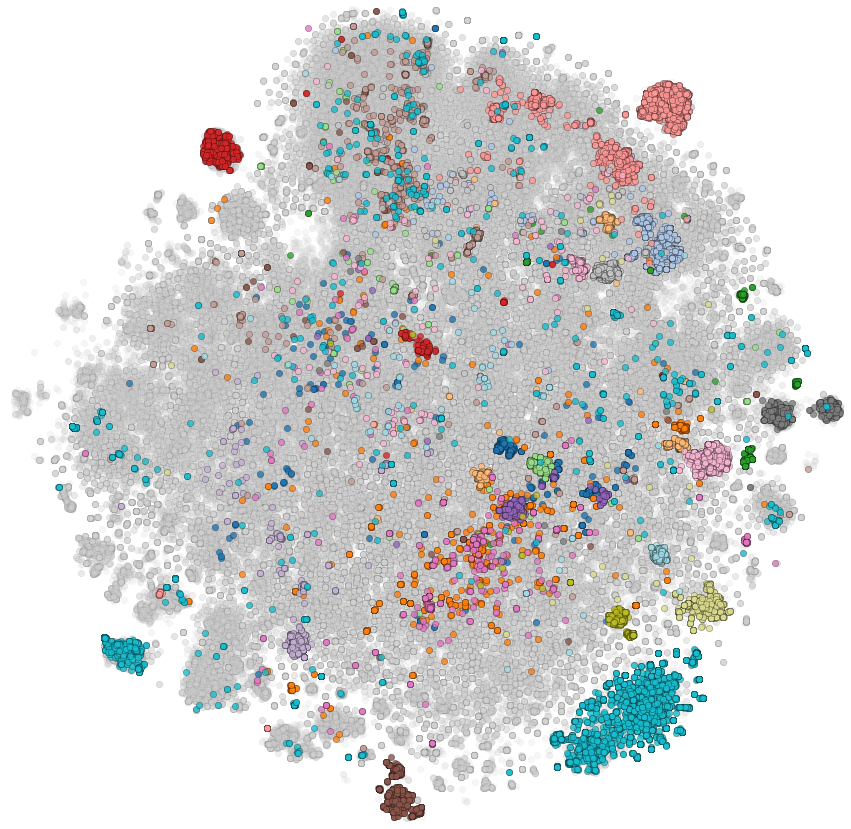

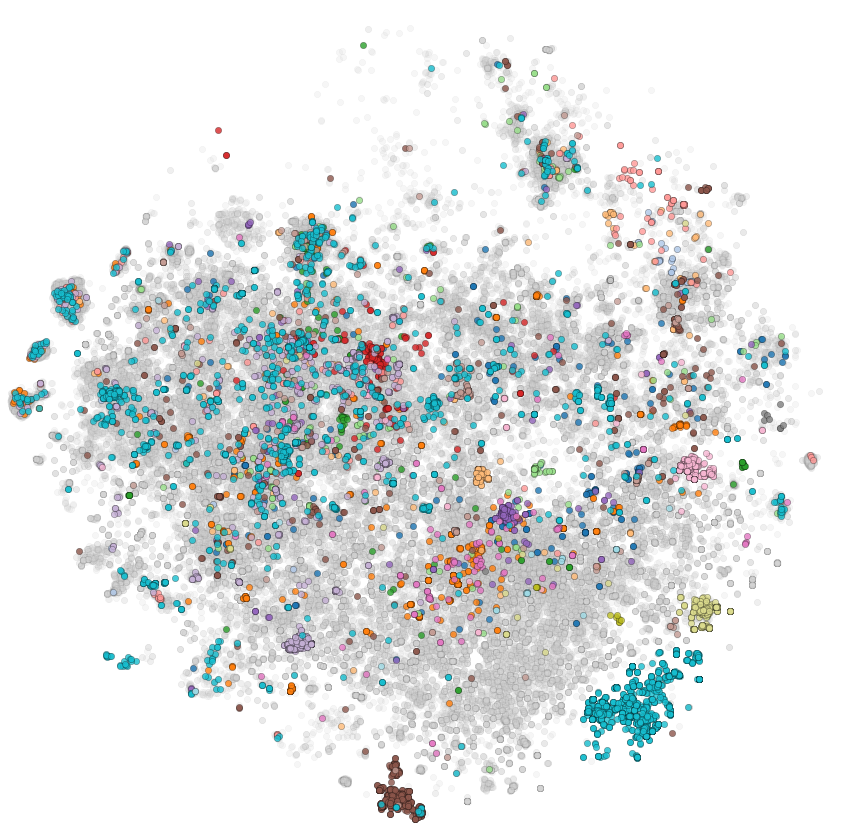

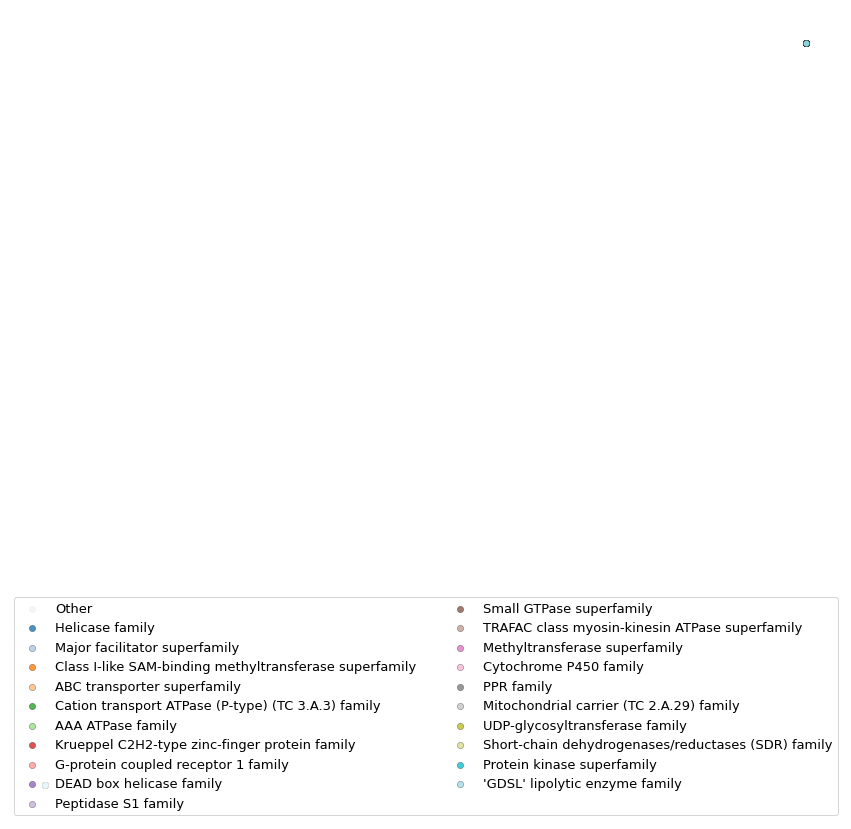

In [6]:
most_common = set(x[0] for x in Counter(AF_dataframe["Protein family"]).most_common(21)[1:])
color_mapping = dict(zip(most_common, range(len(most_common))))
color_mapping_reverse = dict(zip([CMAP_COLORS[i] for i in range(len(most_common))], most_common))
colors = {}
for (k, o) in zip(AF_dataframe.index, AF_dataframe["Protein family"]):
    if o in most_common:
        colors[k] = CMAP_COLORS[color_mapping[o]]
for (k, o) in zip(PDB_dataframe.index, PDB_dataframe["Protein family"]):
    if o in most_common:
        colors[k] = CMAP_COLORS[color_mapping[o]]

list_colors = []
for k in keys:
    if k.startswith("AF-"):
        list_colors.append(colors.get(k, "#D3D3D3"))
    else:
        list_colors.append(colors.get(k[:4], "#D3D3D3"))

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size': 13})

for color in ["#D3D3D3"] + list(CMAP_COLORS):
    indices = np.array([i for i,c in enumerate(list_colors) if c == color])
    af_indices = [i for i in indices if keys[i].startswith("AF-")]
    if color == "#D3D3D3":
        alpha = 0.2
        linewidth=0.1
    else:
        alpha = 0.8
        linewidth=0.3
    ax.scatter(reduced[af_indices, 0], reduced[af_indices, 1],
               label=color_mapping_reverse.get(color, "Other"),
               linewidth=linewidth, edgecolor="black",
               color=color, alpha=alpha, marker="o",
               s=40
              )
plt.xlim(np.min(reduced[:, 0]) - 1, np.max(reduced[:, 0]) + 1)
plt.ylim(np.min(reduced[:, 1]) - 1, np.max(reduced[:, 1]) + 1)
plt.axis('off')
plt.savefig("fig1_af_tsne.svg", dpi=150)

fig, ax = plt.subplots(figsize=(15,15))

for color in ["#D3D3D3"] + list(CMAP_COLORS):
    indices = np.array([i for i,c in enumerate(list_colors) if c == color])
    pdb_indices = [i for i in indices if not keys[i].startswith("AF-")]
    if color == "#D3D3D3":
        alpha = 0.2
        linewidth=0.1
    else:
        alpha = 0.8
        linewidth=0.3
    ax.scatter(reduced[pdb_indices, 0], reduced[pdb_indices, 1],
               label=color_mapping_reverse.get(color, "Other"),
               linewidth=linewidth, edgecolor="black",
               color=color, alpha=alpha, marker="o", s=40)
plt.xlim(np.min(reduced[:, 0]) - 1, np.max(reduced[:, 0]) + 1)
plt.ylim(np.min(reduced[:, 1]) - 1, np.max(reduced[:, 1]) + 1)
plt.axis('off')
plt.savefig("fig1_pdb_tsne.svg", dpi=150)

fig, ax = plt.subplots(figsize=(15,15))

for color in ["#D3D3D3"] + list(CMAP_COLORS):
    if color == "#D3D3D3":
        alpha = 0.2
        linewidth=0.1
    else:
        alpha = 0.8
        linewidth=0.3
    ax.scatter([1, 2], [3, 4],
               label=color_mapping_reverse.get(color, "Other"),
               linewidth=linewidth, edgecolor="black",
               color=color, alpha=alpha, marker="o", s=40)
plt.legend(loc=3,
           ncol=2, mode="expand")
plt.axis('off')
plt.savefig("fig1_legend.svg", dpi=150)

Figure 2: Counts of AF and PDB proteins assigned to each topic

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
w_matrix_norm_both = np.zeros(w_matrix.shape)
scaler_af = StandardScaler()
indices_af = np.array([i for i, x in enumerate(keys) if x.startswith("AF-")])
w_matrix_norm_both[indices_af] = scaler_af.fit_transform(w_matrix[indices_af])
scaler_pdb = StandardScaler()
indices_pdb = np.array([i for i, x in enumerate(keys) if not x.startswith("AF-")])
w_matrix_norm_both[indices_pdb] = scaler_pdb.fit_transform(w_matrix[indices_pdb])

In [12]:
from kneed import KneeLocator

def get_sorted_prot(idx, matrix, S=2, plot=False):
    kn = KneeLocator(np.arange(matrix.shape[0]), 
                     np.sort(matrix[:, idx])[::-1],
                     S=S, 
                     curve='convex', 
                     direction='decreasing')
    if plot:
        print(kn.knee)
        kn.plot_knee()
        plt.show()
    
    return np.array(keys)[np.argsort(matrix[:, idx])[::-1][:kn.knee]], np.sort(matrix[:, idx])[::-1][:kn.knee]

def get_intersecting_topics(idx1, idx2, S=2):
    af_ids1, fs1 = get_sorted_prot(idx1, S=S)
    af_ids2, fs2 = get_sorted_prot(idx2, S=S)
    intersecting_keys, where1, where2 = np.intersect1d(af_ids1, af_ids2, return_indices=True)
    return intersecting_keys, fs1[where1], fs2[where2]

In [13]:
from tqdm import tqdm

In [14]:
topics_to_proteins = {}
for topic_id in tqdm(range(w_matrix.shape[1])):
    protein_ids, scores = get_sorted_prot(topic_id, w_matrix, S=2)
    if scores.sum() == 0:
        topics_to_proteins[topic_id] = []
    else:
        topics_to_proteins[topic_id] = list(zip(list(protein_ids), list(scores)))

  5%|▍         | 12/250 [00:04<01:33,  2.54it/s]/mnt/backup2/geometric/geo_env/lib/python3.8/site-packages/kneed/knee_locator.py:218: RuntimeWarning: invalid value encountered in true_divide
  return (a - min(a)) / (max(a) - min(a))
/mnt/backup2/geometric/geo_env/lib/python3.8/site-packages/kneed/knee_locator.py:237: RuntimeWarning: No local maxima found in the difference curve
The line is probably not polynomial, try plotting
the difference curve with plt.plot(knee.x_difference, knee.y_difference)
Also check that you aren't mistakenly setting the curve argument
  warnings.warn(
100%|██████████| 250/250 [01:37<00:00,  2.58it/s]


In [15]:
protein_to_topics = {}
for topic_id, prots in topics_to_proteins.items():
    for prot_id, score in prots:
        if prot_id not in protein_to_topics:
            protein_to_topics[prot_id] = [(topic_id, score)]
        else:
            protein_to_topics[prot_id].append((topic_id, score))
for protein_id in protein_to_topics:
    protein_to_topics[protein_id] = list(sorted(protein_to_topics[protein_id], key=lambda x: x[1], reverse=True))

In [16]:
len(protein_to_topics), len(keys)

(251836, 400631)

In [26]:
assigned_proteins_txt = open("protein_table.tsv", "w")
assigned_proteins_txt.write(f"Topic id\tprotein count\tAF2 count\tPDB count\tAssigned proteins\n")
for topic, proteins in topics_to_proteins.items():
    protein_ids = [x[0][:-4] if x[0].startswith("AF-") else x[0] for x in proteins]
    total, af_num, pdb_num = len(protein_ids), len([x for x in protein_ids if x.startswith("AF-")]), len([x for x in protein_ids if not x.startswith("AF-")]) 
    proteins_names = ",".join(protein_ids)
    assigned_proteins_txt.write(f"{topic}\t{total}\t{af_num}\t{pdb_num}\t{proteins_names}\n")
assigned_proteins_txt.close()

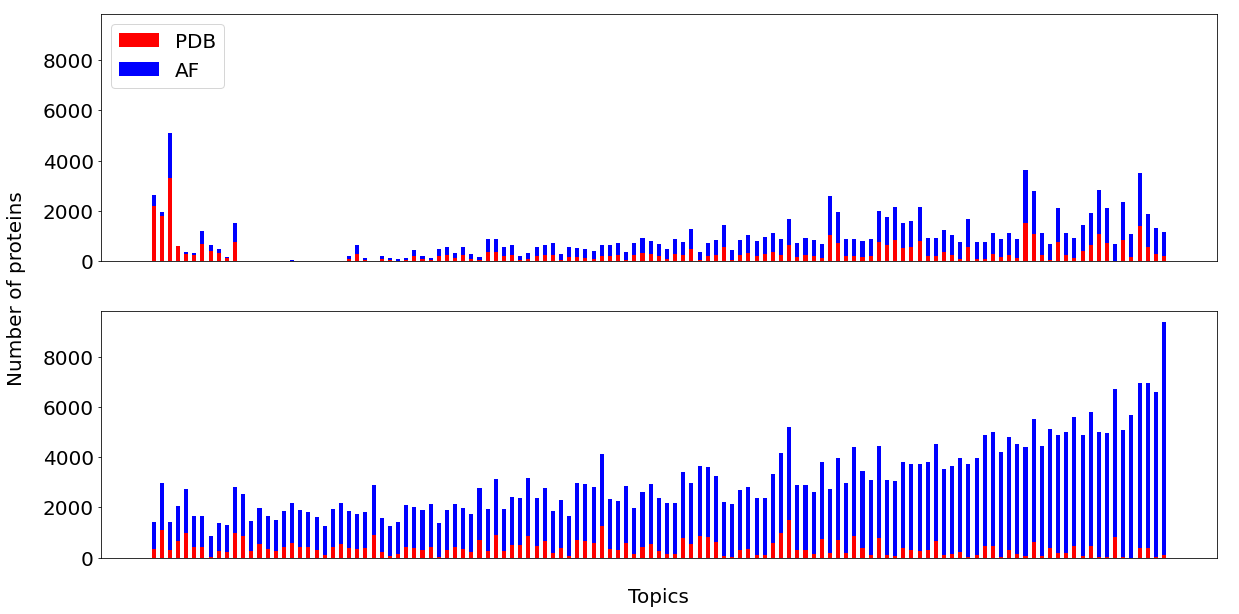

In [27]:
pdb_freqs = np.array([len([x[0] for x in topics_to_proteins[i] if not x[0].startswith("AF-")]) for i in range(250)])
afold_freqs = np.array([len([x[0] for x in topics_to_proteins[i] if x[0].startswith("AF-")]) for i in range(250)])
diff = afold_freqs - pdb_freqs

sort_idx = np.argsort(diff)
pdb_freqs = np.array(pdb_freqs)[sort_idx]
afold_freqs = np.array(afold_freqs)[sort_idx]

plt.rcParams.update({'font.size': 20})
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(2, figsize=(20, 10), sharex="all", sharey="all")
fig.add_subplot(111, frameon=False)
indices = np.arange(250)

num_topics = 250

num = num_topics // 2
rgba_colors = np.zeros((num, 4))
rgba_colors[:,0] = 1.0
rgba_colors[:, 3] = [1 if i in indices else 0.4 for i in range(num)]
rgba_colors1 = np.zeros((num, 4))
rgba_colors1[:,2] = 1.0
rgba_colors1[:, 3] = [1 if i in indices else 0.4 for i in range(num)]

ax[0].bar(np.arange(num), pdb_freqs[:num], width, color=rgba_colors, label='PDB')
ax[0].bar(np.arange(num), afold_freqs[:num], width, color=rgba_colors1, bottom=pdb_freqs[:num], label='AF')
ax[0].set_xticks([])

rgba_colors = np.zeros((num,4))
rgba_colors[:,0] = 1.0
rgba_colors[:, 3] = [1 if i in indices else 0.4 for i in range(num, num*2)]
rgba_colors1 = np.zeros((num,4))
rgba_colors1[:,2] = 1.0
rgba_colors1[:, 3] = [1 if i in indices else 0.4 for i in range(num, num*2)]
ax[1].bar(np.arange(num), pdb_freqs[num:], width, color=rgba_colors, label='PDB')
ax[1].bar(np.arange(num), afold_freqs[num:], width, color=rgba_colors1, bottom=pdb_freqs[num:], label='AF')
ax[1].set_xticks([])

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.text(0.06, 0.5, 'Number of proteins', va='center', rotation='vertical')
plt.xlabel('Topics')
ax[0].legend(loc="upper left")
# plt.savefig("topic_counts.png", dpi=300)

In [70]:
h_matrix = topic_model.components_.copy()
h_matrix_norm = MinMaxScaler().fit_transform(h_matrix)
for i in range(h_matrix_norm.shape[1]):
    current_max = h_matrix_norm[:, i].max()
    h_matrix_norm[:, i] = np.nan_to_num(h_matrix_norm[:, i] / current_max)
feature_names = vectorizer.get_feature_names()
shapemer_to_index = {feature_names[x]: x for x in range(h_matrix_norm.shape[1])}

<ipython-input-70-bec8ad29bdb3>:5: RuntimeWarning: invalid value encountered in true_divide
  h_matrix_norm[:, i] = np.nan_to_num(h_matrix_norm[:, i] / current_max)


In [92]:
max_value = 4

In [71]:
def plot_prot_topic(prot_id, topic_id):
    coords, weights, opacities = plotting.get_protein_topic_scores(folder_mapping[prot_id] / f"{prot_id}.gz",
                                                                       topic_id,
                                                                       h_matrix_norm,
                                                                       shapemer_to_index)

    fig, ax = plotting.plot_protein(coords, weights, opacities, max_value)
    return fig, ax

In [24]:
folder_mapping = {}
for folder in DATA_FOLDER.iterdir():
    if folder.is_dir() and folder.stem.startswith("UP0"):
        for pdb_file in folder.glob("*.pdb.gz"):
            folder_mapping[pdb_file.stem] = folder

In [140]:
plt.rcParams.update({'font.size': 15})
def summarize_topic(idx):
    topic_keys = [i for i, x in topics_to_proteins[idx]]
    af_topic_keys = [x for x in topic_keys if x.startswith("AF-")]
    pdb_topic_keys = [x for x in topic_keys if not x.startswith("AF-")]
    print(f"Topic {idx} has {len(af_topic_keys)} AF proteins and {len(pdb_topic_keys)} PDB proteins assigned to it")
    topic_AF_dataframe = AF_dataframe[AF_dataframe.index.isin(set(af_topic_keys))]
    topic_PDB_dataframe = PDB_dataframe[PDB_dataframe.index.isin(set(x[:4] for x in pdb_topic_keys))]
    for name, dataframe in zip(["AF", "PDB"], [topic_AF_dataframe, topic_PDB_dataframe]):
        print(f"Most common {name} organisms:")
        for n, c in Counter(dataframe["Organism"]).most_common(5):
            print(n, c)
        print("\n")
        if name == "PDB":
            continue
        print(f"Most common {name} superfamilies:")
        for n, c in Counter(dataframe["Protein family"]).most_common(5):
            print(n, c)
        print("\n")
        print(f"Most common {name} families:")
        for n, c in Counter(dataframe["Protein families"]).most_common(5):
            print(n, c)
        print("\n")
        print(f"Most common {name} GO terms:")
        for go_name in ["Gene ontology (molecular function)",
                     "Gene ontology (biological process)",
                     "Gene ontology (cellular component)"]:
            print(go_name)
            terms = []
            for line in dataframe[go_name]:
                if type(line) == str:
                    terms += [x.strip() for x in line.split(";")]
            for n, c in Counter(terms).most_common(5):
                print(n, c)
            print()
        print(f"Most common {name} Pfam domains:")
        terms = []
        for line in dataframe["Cross-reference (Pfam)"]:
            if type(line) == str:
                terms += line[:-1].split(";")
        for n, c in Counter(terms).most_common(5):
                print(n, c)
        print("\n")
    print("Average AF protein score:", np.nanmean(topic_AF_dataframe["Avg. score"]))
    print("Average AF protein length:", np.nanmean(topic_AF_dataframe["Length"]))
    print("Average AF high confidence length:", np.nanmean(topic_AF_dataframe["High confidence length"]))
    print()
    print("Average PDB protein length:", np.nanmean([len(pdb_coords[key]) for key in pdb_topic_keys]))
    print("Some example AF proteins")
    for i in range(min(5, len(af_topic_keys))):
        fig, ax = plot_prot_topic(af_topic_keys[i], idx)
        ax.set_title(af_topic_keys[i])
    plt.show()
    print()
    print("Some example PDB proteins")
    for i in range(min(5, len(pdb_topic_keys))):
        weights = plotting.get_coords_topic_scores(pdb_coords[pdb_topic_keys[i]], 
                                                   idx, 
                                                   h_matrix_norm, 
                                                   shapemer_to_index)
        fig, ax = plotting.plot_protein(pdb_coords[pdb_topic_keys[i]], weights, np.ones(weights.shape), max_value)
        ax.set_title(pdb_topic_keys[i])
    plt.show()

In [134]:
import subprocess
import prody as pd

def save_topic_pdbs(idx, output_folder):
    per_organism = defaultdict(list)
    for key, _ in topics_to_proteins[idx]:
        if key.startswith("AF-") and key in AF_dataframe.index:
            per_organism[str(AF_dataframe.loc[key]["Organism"])].append(key)
    orgs = list(per_organism.keys())
    counts = np.array([len(per_organism[k]) for k in per_organism], dtype=float)
    counts /= np.sum(counts)
    orgs = [(orgs[o], counts[o]) for o in np.argsort(counts)[::-1]]
    chosen_keys = []
    current_keys = set()
    i = 0
    while i < 9:
        index = np.random.choice(np.arange(0, len(orgs)), p=[o[1] for o in orgs])
        new_key = per_organism[orgs[index][0]][np.random.randint(0, len(per_organism[orgs[index][0]]))]
        if new_key not in current_keys:
            current_keys.add(new_key)
            chosen_keys.append((orgs[index][0], 
                               new_key))
            i += 1
    folder = output_folder / f"topic_{idx}"
    if not folder.exists():
        folder.mkdir()
    else:
        for file in folder.iterdir():
            file.unlink()
    for org, key in chosen_keys:
        pdb = plotting.get_protein_topic_scores(folder_mapping[key] / f"{key}.gz", idx, h_matrix_norm, shapemer_to_index, matplotlib=False)
        k = key.split("-")[1]
        pd.writePDB(str(folder / f"{k}-{org}"), pdb)
    subprocess.check_call(["zip", "-r", f"{folder}.zip", folder])

In [135]:
folder = Path("topic_image_pdbs")
if not folder.exists():
    folder.mkdir()
paper_topic_indices =  [88, 60, 150, 16, 17, 24, 36, 40, 48]
for idx in paper_topic_indices:
    save_topic_pdbs(idx, folder)